# Autoregressive models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import pickle

import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

Use the following functions to train your models.

In [2]:
def get_cross_entropy_loss(model, x):
    # your code
    return F.cross_entropy(model(x), x.long())

def train_epoch(model, train_loader, optimizer, use_cuda):
    model.train()
  
    train_losses = []
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        loss = get_cross_entropy_loss(model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_model(model, data_loader, use_cuda):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            loss = get_cross_entropy_loss(model, x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_model(model, train_loader, test_loader, epochs, lr, use_cuda=False):
    if use_cuda:
        model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_model(model, test_loader, use_cuda)]
    for epoch in range(epochs):
        model.train()
        train_losses.extend(train_epoch(model, train_loader, optimizer, use_cuda))
        test_loss = eval_model(model, test_loader, use_cuda)
        test_losses.append(test_loss)

    return train_losses, test_losses

## Task 1: 1D histogram

In this task you should train histogram model on discrete 1D data.

In [3]:
def generate_1d_data(count, bins):
    np.random.seed(42)
    a = 0.2 + 0.05 * np.random.randn(count)
    b = 0.6 + 0.15 * np.random.randn(count)
    mask = np.random.rand(count) < 0.5
    samples = (a * mask + b * (1 - mask)) * (bins - 1)
    data = np.clip(samples.astype('int'), 0.0, (bins - 1))
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data


def plot_1d_data(train_data, test_data):
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('train')
    ax1.hist(train_data, bins=bins, density=True)
    ax1.set_xlabel('x')
    ax2.set_title('test')
    ax2.hist(test_data, bins=np.arange(bins), density=True)
    plt.show()
    
    
def plot_training_curves(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title('training curves')
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    
    
def plot_1d_distribution(data, distribution):
    size = len(distribution)

    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=np.arange(size) - 0.5, label='train data', density=True)

    x = np.linspace(-0.5, size - 0.5, 1000)
    y = distribution.repeat_interleave(1000 // size)
    #поменяла repeat на repeat_interleave
    plt.plot(x, y, label='learned distribution')

    plt.title('learned distribution')
    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.legend()

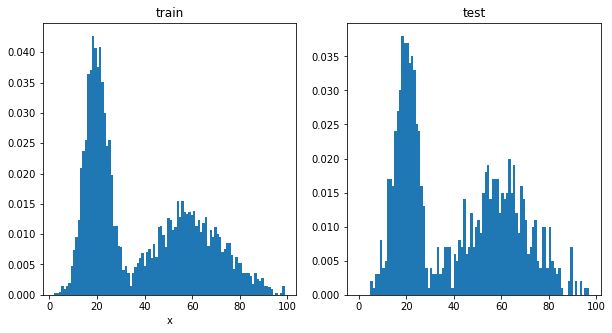

In [52]:
BINS = 100
COUNT = 5000

train_data, test_data = generate_1d_data(COUNT, BINS)
plot_1d_data(train_data, test_data)

Let $\theta = (\theta_0, \dots, \theta_{d}) \in \mathbb{R}^{d}$ are model parameters. Your model is a softmax function: $p(k| \theta) = \frac{e^{\theta_k}}{\sum_{l=1}^d e^{\theta_{l}}}$.

The goal is to train $p(k| \theta)$ using maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. 

In [53]:
class SoftmaxModel(nn.Module):
    def __init__(self, bins):
        super().__init__()
        self.bins = bins
        self.logits = nn.Parameter(torch.zeros(bins))
        
    def forward(self, x):
        # your code
        # from https://github.com/rll/deepul/blob/master/demos/lecture2_autoregressive_models_demos.ipynb 
        return model.logits.unsqueeze(0).repeat(x.shape[0], 1)
             
def get_distribution(model):
    # your code
    # from https://github.com/rll/deepul/blob/master/demos/lecture2_autoregressive_models_demos.ipynb 
    with torch.no_grad():
        y = F.softmax(model.logits, dim=0).unsqueeze(1)
    return y 

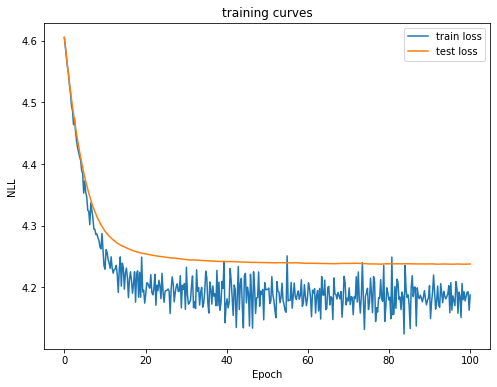

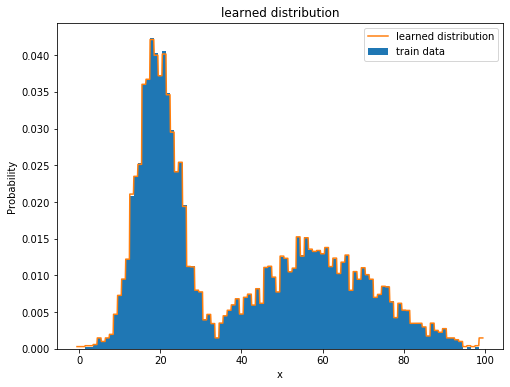

In [54]:
# you have to choose these parameters by yourself
BATCH_SIZE = 1000
EPOCHS = 100
LR = 2.5e-2
USE_CUDA = False

model = SoftmaxModel(BINS)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_cuda=USE_CUDA)
distribution = get_distribution(model)

plot_training_curves(train_losses, test_losses)
plot_1d_distribution(train_data, distribution)

## Task 2: MADE

Train MADE model on single image (https://arxiv.org/abs/1502.03509)

In [4]:
def generate_2d_data(count, bins):
    im = Image.open('dgm.png').resize((bins, bins)).convert('L')
    im = np.array(im).astype('float32')
    dist = im / im.sum()

    pairs = list(itertools.product(range(bins), range(bins)))
    idxs = np.random.choice(len(pairs), size=count, replace=True, p=dist.reshape(-1))
    samples = np.array([pairs[i] for i in idxs])

    split = int(0.8 * len(samples))
    return dist, samples[:split], samples[split:]


def plot_2d_data(train_data, test_data):
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    train_dist, test_dist = np.zeros((bins, bins)), np.zeros((bins, bins))
    for i in range(len(train_data)):
        train_dist[train_data[i][0], train_data[i][1]] += 1
    train_dist /= train_dist.sum()

    for i in range(len(test_data)):
        test_dist[test_data[i][0], test_data[i][1]] += 1
    test_dist /= test_dist.sum()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.set_title('Train Data')
    ax1.imshow(train_dist, cmap='gray')
    ax1.axis('off')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x0')

    ax2.set_title('Test Data')
    ax2.imshow(test_dist, cmap='gray')
    ax2.axis('off')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x0')

    plt.show()
    
    
def plot_2d_distribution(true_dist, learned_dist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.imshow(true_dist, cmap='gray')
    ax1.set_title('True Distribution')
    ax1.axis('off')
    ax2.imshow(learned_dist, cmap='gray')
    ax2.set_title('Learned Distribution')
    ax2.axis('off')

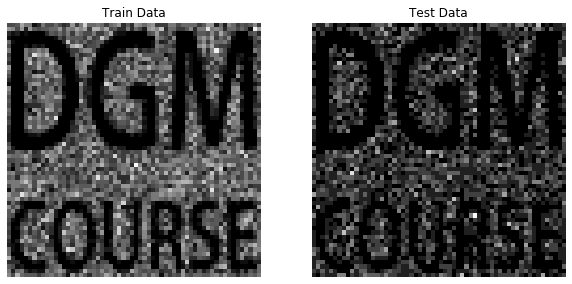

In [5]:
COUNT = 20000
BINS = 60

image, train_data, test_data = generate_2d_data(COUNT, BINS)
plot_2d_data(train_data, test_data)

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
def to_one_hot(labels, d):
    one_hot = torch.FloatTensor(labels.shape[0], d).to(labels.device)
    one_hot.zero_()
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot


class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

    
class MADE(nn.Module):
    def __init__(self, nin, bins, hidden_sizes):
        super().__init__()
        self.nin = nin
        self.nout = self.nin * bins
        self.bins = bins
        self.hidden_sizes = hidden_sizes
        self.ordering = np.arange(self.nin)

        # define a simple MLP neural net
        # from https://github.com/karpathy/pytorch-made/blob/master/made.py
        self.net = []
        hs = [nin*bins] + hidden_sizes + [self.nout] # add *bins 
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop()
        self.net = nn.Sequential(*self.net)
        self.seed = 0
        self.m = {}
        
        self.create_mask()  # builds the initial self.m connectivity

        
    def create_mask(self):
        self.masks = []
        # your code
        # from https://github.com/karpathy/pytorch-made/blob/master/made.py

        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) 
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin*self.bins)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
            #self.m[l] = rng.randint(self.m[l-1].min(), self.nout, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        self.masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        self.masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
                
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, self.masks):           
            l.set_mask(m)

    def visualize_masks(self):
        for m in self.masks:
            plt.figure(figsize=(5, 5))
            plt.imshow(m, cmap='gray')
            plt.show()

    def forward(self, x):
        # your code
        #from https://github.com/rll/deepul/blob/master/homeworks/solutions/hw1_solutions.ipynb
        batch_size = x.shape[0]
        x = x.long().reshape(-1) 
        x = to_one_hot(x, self.bins)
        x = x.view(batch_size, -1)
        logits = self.net(x).view(batch_size, self.nin, self.bins)
        return logits.permute(0, 2, 1).contiguous().view(batch_size, self.bins, (self.nin))
        


def get_distribution(model):
    # your code
    #from https://github.com/rll/deepul/blob/master/homeworks/solutions/hw1_solutions.ipynb
    x = np.mgrid[0:model.bins, 0:model.bins].reshape(2, model.bins**2).T
    x = torch.LongTensor(x) 
    log_probs = F.log_softmax(model(x), dim=1)
    distribution = torch.gather(log_probs, 1, x.unsqueeze(1)).squeeze(1)
    distribution = distribution.sum(dim=1)
    return distribution.exp().view(model.bins, model.bins).detach().cpu().numpy()

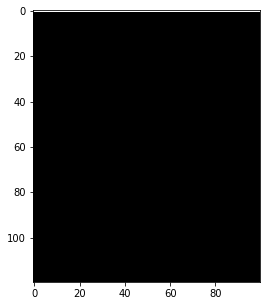

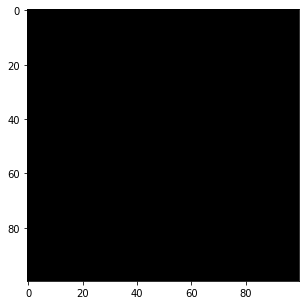

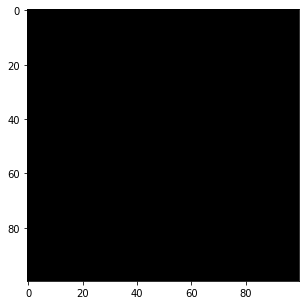

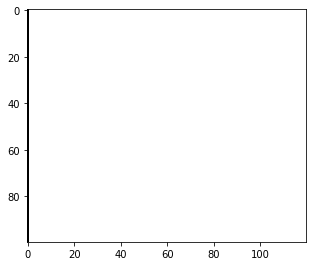

In [ ]:
# you have to choose these parameters by yourself
BATCH_SIZE = 100
EPOCHS = 200
LR = 1e-2
USE_CUDA = False
HIDDEN_SIZES = [100,100,100]


model = MADE(2, BINS, HIDDEN_SIZES)
model.visualize_masks()
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_cuda=USE_CUDA)

distribution = get_distribution(model)
plot_training_curves(train_losses, test_losses)
plot_2d_distribution(image, distribution)

In [ ]:
BATCH_SIZE = 500
EPOCHS = 600
LR = 2e-2
USE_CUDA = False
HIDDEN_SIZES = []


model = MADE(2, BINS, HIDDEN_SIZES)
model.visualize_masks()
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_cuda=USE_CUDA)

distribution = get_distribution(model)
plot_training_curves(train_losses, test_losses)
plot_2d_distribution(image, distribution)